In [4]:
%matplotlib inline


#path = "~/nbs/s3-data/dogscats-kaggle/"
import utils; reload(utils)
from utils import plots

batch_size=64

import vgg16; reload(vgg16)
from vgg16 import Vgg16

vgg = Vgg16()

Found 160 images belonging to 2 classes.


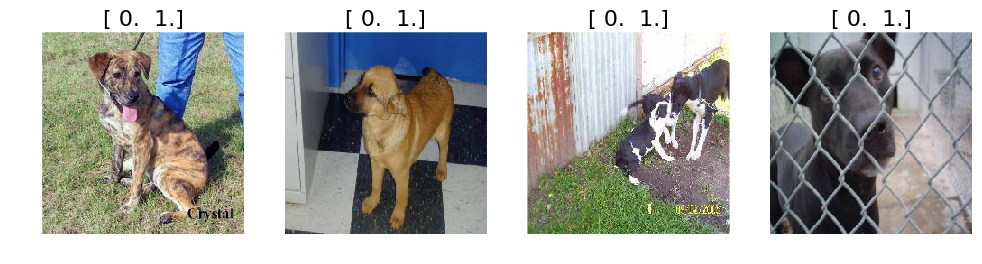

In [6]:
#sanity check
path = "../../data/dogscats/sample/"

batches = vgg.get_batches(path+'train', batch_size=4)
imgs,labels = next(batches)
plots(imgs, titles=labels)


In [9]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [10]:

#heavy lifting

# s3-data is mounted via s3fs and refers to the s3 bucket 'dogs-cats-redux-data'
#path = "~/nbs/s3-data/dogscats-kaggle/"

batch_size=64
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)
vgg.finetune(batches)

vgg.fit(batches, val_batches, nb_epoch=1)


Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/1
160/160 [==============================] - 55s - loss: 1.1996 - acc: 0.6500 - val_loss: 0.1713 - val_acc: 0.9250


In [12]:
#get test data
test_batches = utils.get_batches(path+'test-sample', shuffle=False, batch_size=1, class_mode=None)
test_imgs = np.concatenate([test_batches.next() for i in range(test_batches.nb_sample)])
imgs_files = test_batches.filenames


Found 125 images belonging to 1 classes.


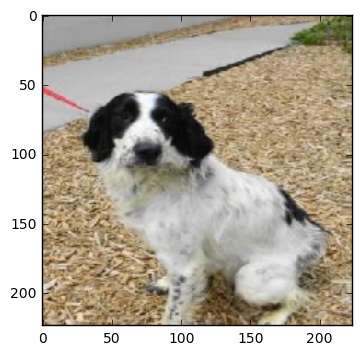

In [58]:
#sanity-check
imgs_files[:4]
plots(test_imgs[:4])

#for i in range(len(imgs_files)):
#    if imgs_files[i] == 'tmp/12430.jpg':
#        break

#ims = test_imgs[i]
#ims = np.array(ims).astype(np.uint8)
#ims = ims.transpose((1,2,0))
#plt.imshow(ims)


In [15]:
import re
#predict
predictions, idxs, classes = vgg.predict(test_imgs)
dogs_proba = [predictions[i] if classes[i] == 'dogs' else (1.0-predictions[i]) for i in range(len(idxs))]
image_proba_dict = {}

for fn, pred, clazz in zip(imgs_files, predictions, classes):
    #round up if we're pretty sure
    pred = 0.0 if (pred < 0.1) else pred
    pred = 1.0 if (pred > 0.9) else pred 
    # kaggle expects the probability of a dog
    pred = (1-pred) if (clazz == 'cats') else pred
    m = re.search(r'(\d+)', fn)
    image_proba_dict[int(m.group(0))] = pred


In [17]:
image_proba_dict

{9: 0.0,
 18: 0.85915369,
 27: 0.63670641,
 36: 0.0,
 45: 0.0,
 54: 0.0,
 63: 0.0,
 72: 1.0,
 81: 0.20077365636825562,
 90: 0.0,
 126: 0.25502920150756836,
 135: 0.0,
 144: 0.0,
 153: 0.0,
 162: 0.0,
 171: 0.0,
 180: 0.0,
 207: 0.84872848,
 216: 0.42260575294494629,
 225: 0.74983644,
 234: 0.0,
 243: 0.0,
 252: 0.0,
 261: 0.0,
 270: 1.0,
 306: 1.0,
 315: 1.0,
 324: 0.0,
 333: 0.50064063,
 342: 0.0,
 351: 0.0,
 360: 0.0,
 405: 1.0,
 414: 0.0,
 423: 1.0,
 432: 0.0,
 441: 0.0,
 450: 1.0,
 504: 0.0,
 513: 1.0,
 522: 0.0,
 531: 0.53323716,
 540: 1.0,
 603: 0.0,
 612: 1.0,
 621: 0.0,
 630: 1.0,
 702: 0.0,
 711: 0.0,
 720: 0.0,
 801: 0.0,
 810: 0.38806182146072388,
 900: 0.40839052200317383,
 1990: 1.0,
 2890: 0.0,
 2980: 0.0,
 3790: 0.11015397310256958,
 3880: 0.0,
 3970: 0.48447847366333008,
 4690: 0.0,
 4780: 1.0,
 4870: 1.0,
 4960: 0.4201129674911499,
 5590: 1.0,
 5680: 1.0,
 5770: 0.0,
 5860: 1.0,
 5950: 0.0,
 6490: 0.0,
 6580: 0.14770752191543579,
 6670: 1.0,
 6760: 0.0,
 6850: 0.870746

In [48]:
#make submission file
import time

# order by time
sub_name = 'submission-{:d}.csv'.format(int(time.time()))

with open(path+sub_name,'w') as sub:
    sub.write('id,label\n')
    for k in sorted(image_proba_dict):
        sub.write("{:d},{:.4f}\n".format(k, image_proba_dict[k]))
